# OIH Queries 

What follows are some example SPARQL queries used in OIH for the test interface


## Setup and inits

### Installs

In [3]:
%%capture
#@title
!pip install -q SPARQLWrapper
!pip install -q cython
!pip install -q cartopy
!pip install -q geopandas
!pip install -q contextily==1.0rc2
!pip install pyshacl
!pip install 'PyLD>=2.0.3'
!pip install flatten_json
!pip install 'fsspec>=0.3.3'
!pip install s3fs
!pip install boto3
!pip install -q kglab

### Imports

In [15]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import dask, boto3
import dask.dataframe as dd
import numpy as np
import json
import geopandas
import matplotlib.pyplot as plt
import shapely
import kglab

oih = "https://graph.collaborium.io/blazegraph/namespace/oihdev/sparql"
oihad = "https://graph.collaborium.io/blazegraph/namespace/aquadocs/sparql"
oihobps = "https://graph.collaborium.io/blazegraph/namespace/obps/sparql"
oihlocal = "http://192.168.86.45:49158/blazegraph/namespace/oih/sparql"

### Functions

In [6]:
#@title
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

In [254]:
rq_main = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s  ?wat ?orgname ?domain ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [257]:
df = get_sparql_dataframe(oih, rq_main)
df.head(5)

,g,s,wat,orgname,domain,type,score,name,url,lit,description,headline
0,urn:gleaner:milled:obis:13392d707024cdd4e509d6...,t12576,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/b91d89db-79d6-4bd3-84...,coral,The purpose of the Coral Reef Evaluation and M...,None
1,urn:gleaner:milled:obis:18d1180a74c200d06f9114...,t13860,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/46005357-02b8-4f17-b0...,coral,The purpose of the Coral Reef Evaluation and M...,None
2,urn:gleaner:milled:obis:24bac898cda34444176ec4...,t16445,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/d4ec17b8-fc96-49b9-b7...,coral,The purpose of the Coral Reef Evaluation and M...,None
3,urn:gleaner:milled:obis:24d453e3a4ea6d1f117e5c...,t16471,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/36bca81c-6d77-4fd4-a9...,coral,The purpose of the Coral Reef Evaluation and M...,None
4,urn:gleaner:milled:obis:2524f94920efb8f87029bf...,t16581,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Interacciones entre Corales y CÃ©spedes algale...,https://obis.org/dataset/e39be6ef-3c91-4e97-ba...,coral,Para el componente denominado âInteracciÃ³n ...,None


## AquaDocs Alignment Testing

When pulling in documents using the graph only pattern there can be issues with how the prov looks and works for one large document vs many individual ones.  This is a test of that

In [225]:
df = get_sparql_dataframe(oihad, rq_main)
df.head(5)

,g,s,wat,orgname,domain,type,score,name,url,lit,description,headline
0,urn:gleaner:summoned:obps:466a3efb3402cd6c0b53...,oai:repository.oceanbestpractices.org:11329/1350,https://www.re3data.org/repository/obps,Ocean Best Practices,https://oih.oceanbestpractices.org,https://schema.org/CreativeWork,0.625,Next-Generation Optical Sensing Technologies f...,https://www.oceandocs.org/handle/11329/1350,Coral reefs,- We highlight three emerging NASA optical te...,None
1,urn:gleaner:summoned:obps:466a3efb3402cd6c0b53...,oai:repository.oceanbestpractices.org:11329/447,https://www.re3data.org/repository/obps,Ocean Best Practices,https://oih.oceanbestpractices.org,https://schema.org/CreativeWork,0.625,Standardised survey procedures for monitoring ...,https://www.oceandocs.org/handle/11329/447,Coral reefs,- This manual describes the standard Reef L...,None
2,urn:gleaner:summoned:obps:466a3efb3402cd6c0b53...,oai:repository.oceanbestpractices.org:11329/445,https://www.re3data.org/repository/obps,Ocean Best Practices,https://oih.oceanbestpractices.org,https://schema.org/CreativeWork,0.625,Best practices in RNA & DNA sample preparation...,https://www.oceandocs.org/handle/11329/445,Coral reefs,"- When the ocean is dying, the planet is...",None
3,urn:gleaner:summoned:obps:466a3efb3402cd6c0b53...,oai:repository.oceanbestpractices.org:11329/448,https://www.re3data.org/repository/obps,Ocean Best Practices,https://oih.oceanbestpractices.org,https://schema.org/CreativeWork,0.625,Systematic global assessment of reef fish comm...,https://www.oceandocs.org/handle/11329/448,Coral reefs,- Discussion of the Reef Life Survey Methods ...,None
4,urn:gleaner:summoned:obps:466a3efb3402cd6c0b53...,oai:repository.oceanbestpractices.org:11329/760,https://www.re3data.org/repository/obps,Ocean Best Practices,https://oih.oceanbestpractices.org,https://schema.org/CreativeWork,0.625,Recommendations for best practice in deep-sea ...,https://www.oceandocs.org/handle/11329/760,Coral gardens,- We assert that the reef framework-forming c...,None


## Query for prov

Count (count(distinct ?tag) as ?count) 

Need to look for the date in the prov record too.  I keep it by day granularity, so I should be able to see the difference if I focos on a specific repo or look over the dates

In [200]:
rq_prov = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?hm) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?wat ?orgname ?domain
        """

In [203]:
dfp = get_sparql_dataframe(oih, rq_prov)
dfp['count'] = dfp["count"].astype(int) # convert count c to int
dfp.set_index('orgname', inplace=True)
dfp.head(10)

,count,wat,domain
orgname,,,
Samples Earth (DEMO Site),202,https://www.re3data.org/repository/samplesearth,https://samples.earth
Ocean Biodiversity Information System,4007,https://www.re3data.org/repository/obis,https://obis.org
Marine Training EU,313,https://www.re3data.org/repository/marinetraining,https://marinetraining.eu/
IODE OceanExpert,487,https://www.re3data.org/repository/oceanexpert,https://oceanexpert.org/


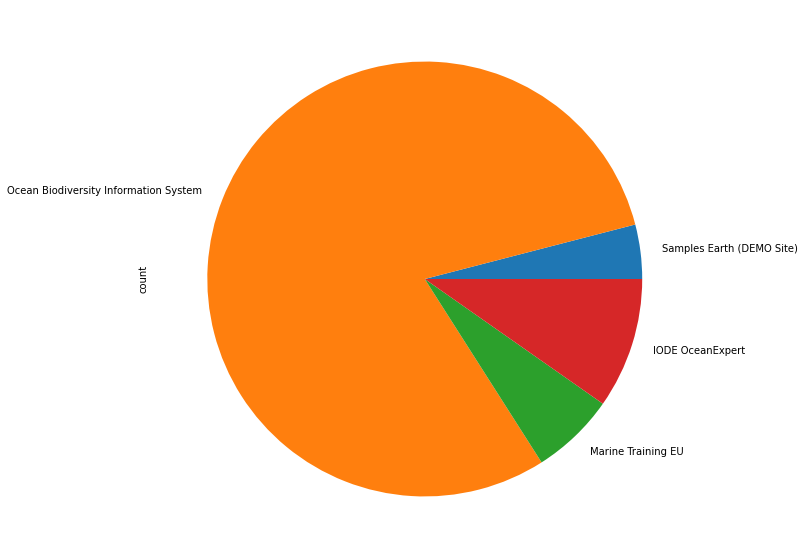

In [268]:
plot = dfp.plot.pie(y='count',legend=False, figsize=(10, 10))

In [205]:
rq_provdate = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?s) as ?count) ?time ?orgname  
        WHERE
        {
           ?s a prov:Activity  .
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?time ?orgname  
        """

In [206]:
dfpd = get_sparql_dataframe(oih, rq_provdate)
dfpd.head(10)

,count,time,orgname
0,4007,2021-04-20T00:00:00.000Z,Ocean Biodiversity Information System
1,202,2021-04-16T00:00:00.000Z,Samples Earth (DEMO Site)
2,202,2021-04-20T00:00:00.000Z,Samples Earth (DEMO Site)
3,487,2021-04-24T00:00:00.000Z,IODE OceanExpert
4,313,2021-05-12T00:00:00.000Z,Marine Training EU
5,485,2021-04-20T00:00:00.000Z,IODE OceanExpert


In [216]:
dfpd = get_sparql_dataframe(oih, rq_provdate)
dfpd['count'] = dfpd["count"].astype(int) # convert count c to int
dfpd.set_index('time', inplace=True)
dfpd.head()


,count,orgname
time,,
2021-04-16T00:00:00.000Z,202,Samples Earth (DEMO Site)
2021-04-20T00:00:00.000Z,202,Samples Earth (DEMO Site)
2021-04-20T00:00:00.000Z,4007,Ocean Biodiversity Information System
2021-05-12T00:00:00.000Z,313,Marine Training EU
2021-04-24T00:00:00.000Z,487,IODE OceanExpert


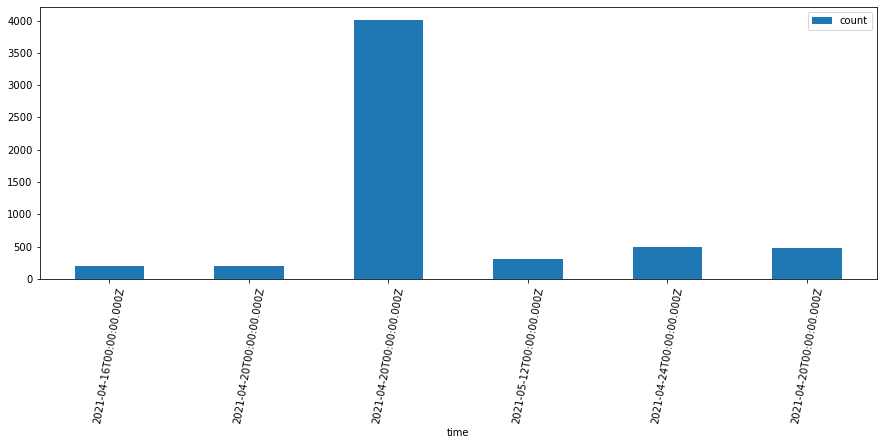

In [271]:
ax = dfpd.plot.bar(rot=80, stacked=True, figsize=(15, 5))

## Feed query

Goal here is see if the prov will give us the elements for an RSS feed.  
The [RSS specs](https://validator.w3.org/feed/docs/rss2.html) give us the elements we need to populate.  Focus on; title(name), date, author, description

* Element 	Description 	Example
* title 	The title of the item. 	Venice Film Festival Tries to Quit Sinking
* link 	The URL of the item. 	http://www.nytimes.com/2002/09/07/movies/07FEST.html
* description 	The item synopsis. 	Some of the most heated chatter at the Venice Film Festival this week was about the way that the arrival of the stars at the Palazzo del Cinema was being staged.
* author 	Email address of the author of the item. More. 	oprah@oxygen.net
* category 	Includes the item in one or more categories. More. 	Simpsons Characters
* comments 	URL of a page for comments relating to the item. More. 	http://www.myblog.org/cgi-local/mt/mt-comments.cgi?entry_id=290
* enclosure 	Describes a media object that is attached to the item. More. 	<enclosure url="http://live.curry.com/mp3/celebritySCms.mp3" length="1069871" type="audio/mpeg"/>
* guid 	A string that uniquely identifies the item. More. 	<guid isPermaLink="true">http://inessential.com/2002/09/01.php#a2</guid>
* pubDate 	Indicates when the item was published. More. 	Sun, 19 May 2002 15:21:36 GMT
* source 	The RSS channel that the item came from. More. 	<source url="http://www.quotationspage.com/data/qotd.rss">Quotes of the Day</source>

In [252]:
rq_provdatelist = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT  ?time ?orgname ?memval  ?memname ?memdesc
        WHERE
        {
           ?s a prov:Activity  .
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:value ?memval .
           ?mem schema:name ?memname .
           ?mem schema:description ?memdesc .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        ORDER BY DESC(?time)
        LIMIT 1000

        """

In [253]:
dfpl = get_sparql_dataframe(oih, rq_provdatelist)
dfpl.head(10)

,time,orgname,memval,memname,memdesc
0,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4051,Stochastic and Nonlinear Ocean Waves,Kort om emnet\n\nDet gis en introduksjon til s...
1,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/3978,Water Chemistry,Water chemistry introduces the principles and ...
2,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4394,Behavioural Ecology,Course Description:\n\nBoth undergraduates and...
3,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4338,Geographical Information System,Course Description:\n\nThe course provides an ...
4,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4116,Fisheries Ecology and Assessment,General course objectives\n\nTo provide the pa...
5,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4287,"Research Methods for Fish, Marine and Freshwat...",Course Description:\n\nCurrent methods in stud...
6,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4089,Invasion Biology,Basic concepts in invasion biology. Overview o...
7,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4330,Icelandic Society and Environment,Course Description:\n\nThe course explores the...
8,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4005,Marine Insurance,The Marine Insurance law deals with the rules ...
9,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4396,Fish Reproduction (Graduate),Course Description:\n\nThe aim of the course i...


## Types Breakdown


In [274]:
rq_types = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?type) as ?count) ?type   
        WHERE
        {
           ?s rdf:type ?type
        }
        GROUP BY ?type  
        ORDER BY DESC(?count)
        """

In [275]:
dft = get_sparql_dataframe(oih, rq_types)
dft['count'] = dft["count"].astype(int) # convert count c to int
dft.set_index('type', inplace=True)
dft.head(10)

,count
type,
http://www.w3.org/ns/prov#Entity,11392
https://schema.org/Organization,6025
http://www.w3.org/ns/prov#Activity,5696
http://www.w3.org/ns/prov#Collection,5696
http://www.w3.org/ns/prov#Organization,5696
https://schema.org/Place,4742
https://schema.org/Dataset,4108
https://schema.org/PropertyValue,4068
https://schema.org/DataCatalog,4007


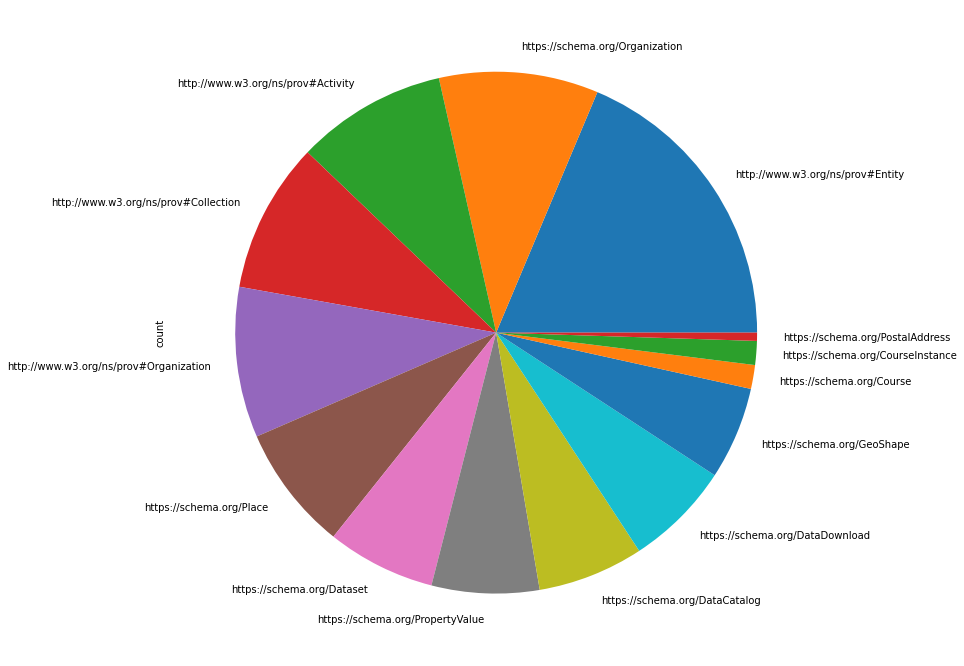

In [276]:
plot_t = dft.plot.pie(y='count',legend=False, figsize=(12, 12))